<a href="https://colab.research.google.com/github/EladGold/Emotion_Detection/blob/main/Final_Project_Emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing external tools
!pip install wandb --upgrade
!pip install torchviz --upgrade
!pip install hiddenlayer --upgrade

Requirement already up-to-date: wandb in /usr/local/lib/python3.7/dist-packages (0.10.20)
Requirement already up-to-date: torchviz in /usr/local/lib/python3.7/dist-packages (0.0.1)
Requirement already up-to-date: hiddenlayer in /usr/local/lib/python3.7/dist-packages (0.3)


In [2]:
# Importing relevant Libraries

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import wandb
import pandas as pd
import seaborn as sns

import torchviz as torchviz
import hiddenlayer as hl
from google.colab import files
from keras.utils import plot_model
from torchviz import make_dot
from graphviz import Source


In [3]:
# Choose GPU if available, else CPU
if torch.cuda.is_available():
    proc = torch.device('cuda')
else:
    proc = torch.device('cpu')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/FinalProject/kaggle.json" ~/.kaggle/

!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
# For competition datasets
!kaggle datasets download -d astraszab/facial-expression-dataset-image-folders-fer2013

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-6p9ckawl/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-6p9ckawl/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-9y2guhah/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
{"username":"eladgold","key":"289c3ed2467eb873ab76ec0bad2e9361"}facial-expression-dataset-image-folders-fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Complete path to storage location of the .zip file of data
zip_path = '../content/drive/MyDrive/facial-expression-dataset-image-folders-fer2013.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
os.getcwd()
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly 
data = !unzip -q 'facial-expression-dataset-image-folders-fer2013.zip'
# View the unzipped contents in the virtual machine
os.listdir()

cp: cannot stat '../content/drive/MyDrive/facial-expression-dataset-image-folders-fer2013.zip': No such file or directory


['.config',
 'wandb',
 'data',
 'drive',
 'facial-expression-dataset-image-folders-fer2013.zip',
 'sample_data']

In [6]:
data_dir = '../content/data'

train = data_dir + '/train'                         # Contains training images
test = data_dir + '/test'                           # Contains test images
val = data_dir + "/val"                             # Contains validation images
print(os.listdir(data_dir))
classes = os.listdir(train)
print(classes)



['val', 'cifar-10-python.tar.gz', 'MNIST', 'test', 'train', 'cifar-10-batches-py']
['4', '3', '2', '5', '1', '0', '6']


In [7]:
#Create data tensors

transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True),
        ]
    )


# Adding the test data into the train data
train_data = torchvision.datasets.ImageFolder(train, transform)
train_data += torchvision.datasets.ImageFolder(test, transform)

validation_data = torchvision.datasets.ImageFolder(val, transform)

In [8]:
print(len(train_data),len(validation_data))

32298 3589


In [9]:
print(train_data[0][0].shape)

torch.Size([3, 48, 48])


In [10]:
# Use dataloaders for train and test (batch size is batchSize)
batchSize = 64
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batchSize,
                                          shuffle=True, num_workers=3, pin_memory=True)

testloader = torch.utils.data.DataLoader(validation_data, batch_size=batchSize,
                                         shuffle=True, num_workers=3, pin_memory=True)

In [11]:
def block(in_channels, out_channels, enabale_dropout, pool=False):
  if enabale_dropout:
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True),
              nn.Dropout2d(0.3)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
  else:
    print(1)
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

#@title 

class EmotionDetect (nn.Module):
    def __init__(self, in_channels, num_classes, enabale_dropout=True):
        super().__init__()
        
        self.conv1 = block(in_channels, 64, enabale_dropout)
        self.conv2 = block(64, 128, enabale_dropout, pool=True)
        self.res1 = nn.Sequential(block(128, 128, enabale_dropout), block(128, 128, enabale_dropout))
        
        self.conv3 = block(128, 512, enabale_dropout, pool=True)
        self.conv4 = block(512, 512, enabale_dropout, pool=True)
        self.res2 = nn.Sequential(block(512, 512, enabale_dropout), block(512, 512, enabale_dropout))

        self.conv5 = block(512, 256, enabale_dropout, pool=True)
        self.conv6 = block(256, 512, enabale_dropout, pool=True)
        self.res3 = nn.Sequential(block(512, 512, enabale_dropout), block(512, 512, enabale_dropout))
        
        self.classifier = nn.Sequential( 
                                nn.Flatten(),
                                nn.Linear(512, num_classes))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.res3(x) + x
        x = self.classifier(x)
        return x

In [12]:
# Initialize a new network
model = EmotionDetect(3,15).to(proc)

# define loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer
max_lr = 0.005
weight_decay = 0.000009
epochs = 15

optimizer = torch.optim.Adam(model.parameters(), lr=max_lr, weight_decay= weight_decay)

In [13]:
# define a scheduler for our lr
schedualer = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,
                                                 epochs= 30,
                                                 steps_per_epoch=len(trainloader))

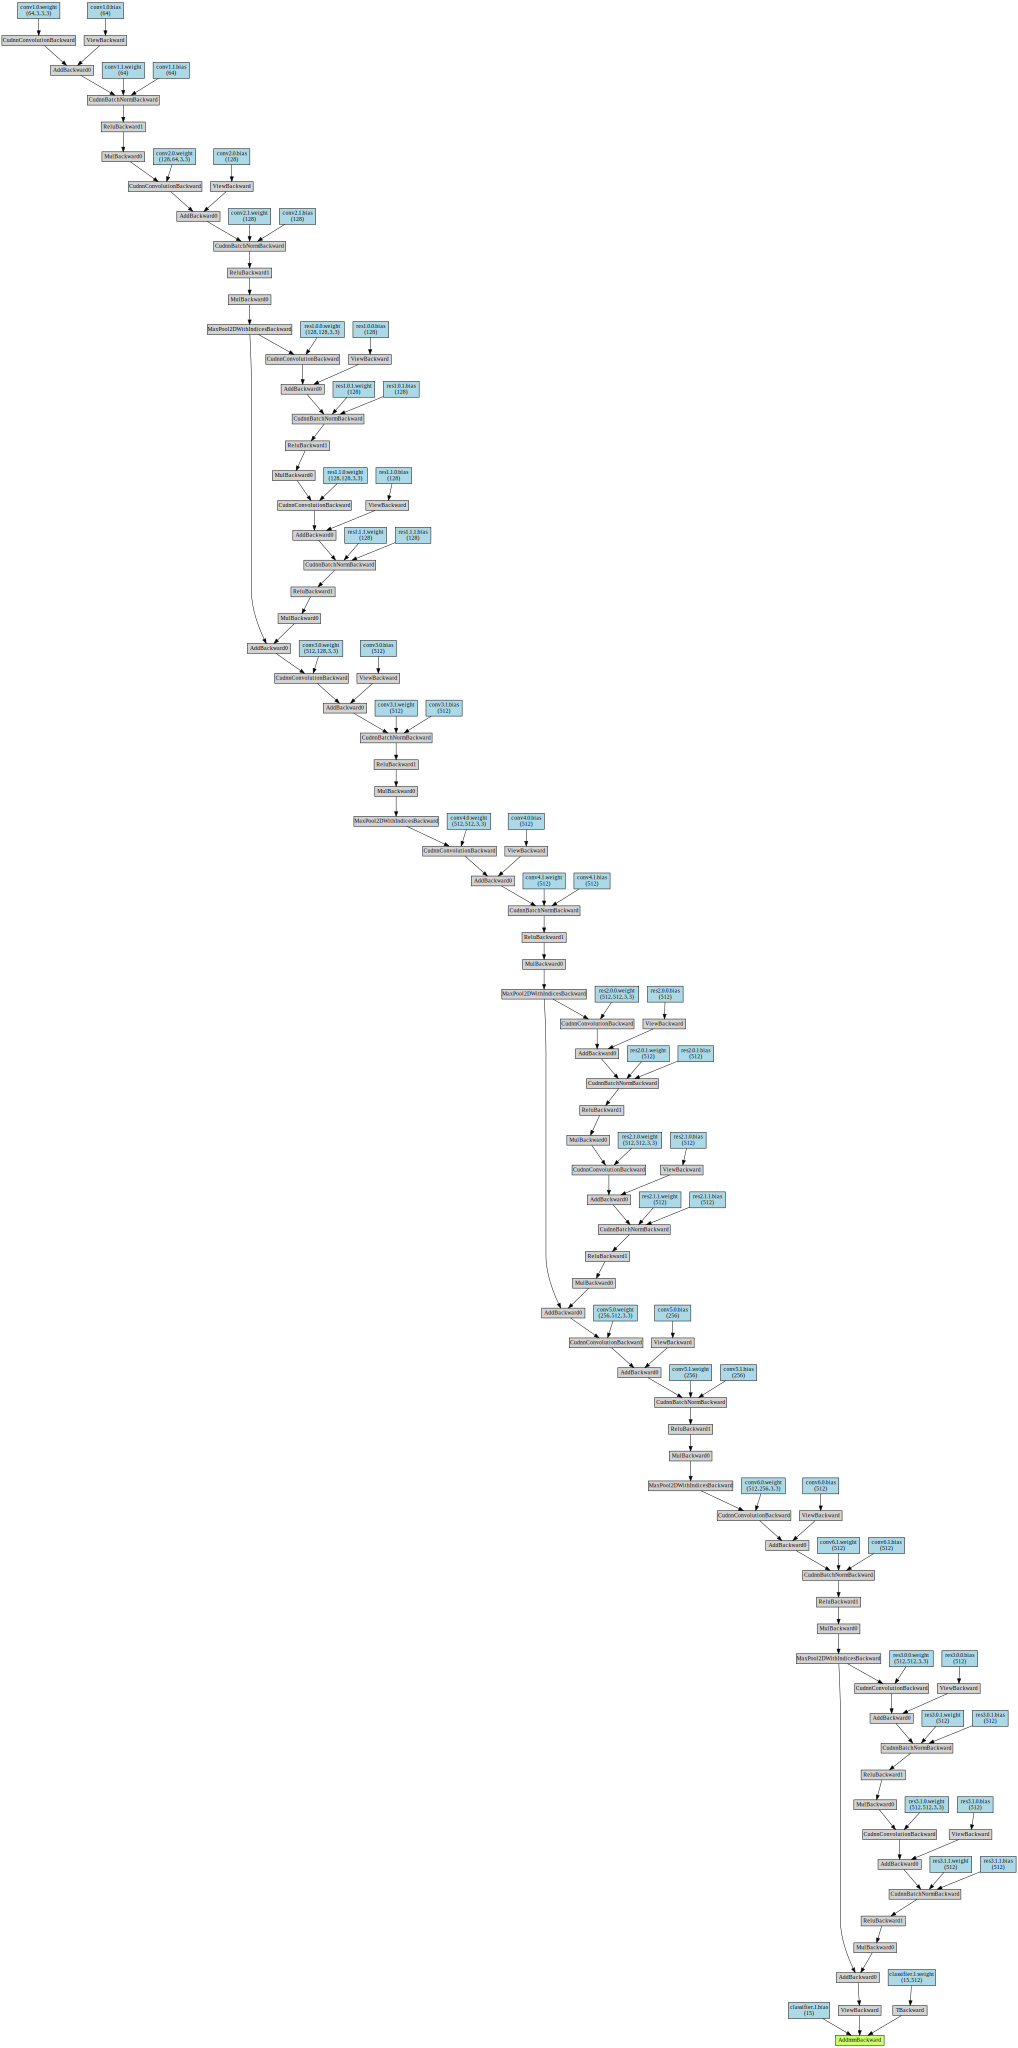

In [14]:
# print our model using torchviz
x = torch.zeros(64, 3, 48, 48, dtype=torch.float, requires_grad=False)
out = model(x.to(proc))
x = make_dot(out, params=dict(model.named_parameters()))
x

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:182: UserWarning: ONNX export failed on feature_dropout because training mode not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


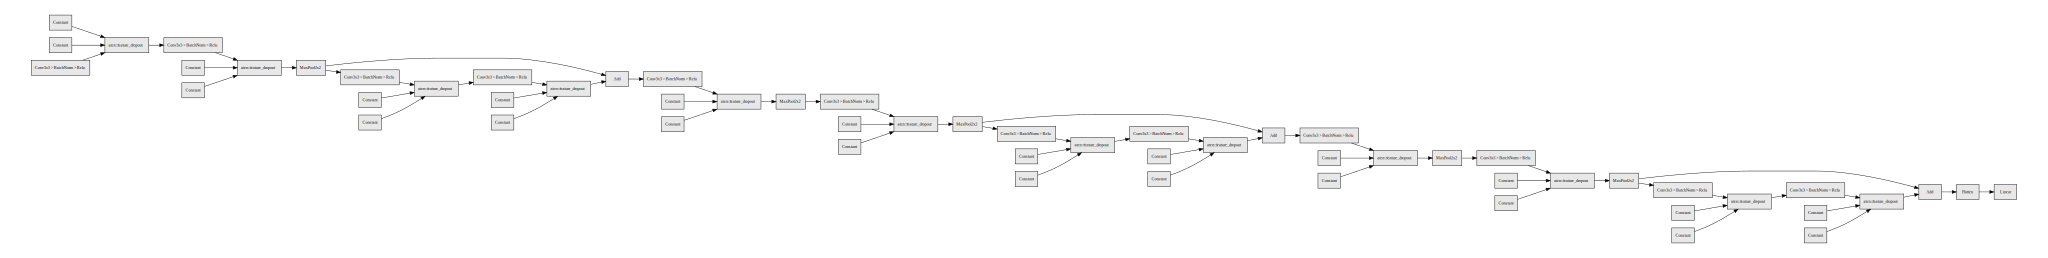

In [15]:
# print out model using hiddenlayer
hl.build_graph(model, torch.zeros([64, 3, 48, 48]).to(proc))

In [16]:
# 1. Start a new run
wandb.init(project="final_proj", entity="eladg")

# 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = 0.002

# 3. Log gradients and model parameters
wandb.watch(model)    



wandb: Currently logged in as: eladg (use `wandb login --relogin` to force relogin)


In [17]:
#Create pretrained data tensors 
transform2 = transforms.Compose([
                                 transforms.Resize((48,48)),
                                torchvision.transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
pretrainset = torchvision.datasets.CIFAR10(root='./data',
                                  train=True,
                                  download=True,
                                  transform=transform2)
transform3 = transforms.Compose([
                                 transforms.Resize((48,48)),
                                torchvision.transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
pretrainset2 = torchvision.datasets.MNIST(root='./data',
                                  train=True,
                                  download=True,
                                  transform=transform3)



Files already downloaded and verified


In [18]:
  trainloader2 = torch.utils.data.DataLoader(pretrainset, batch_size=64,
                                          shuffle=True, num_workers=3, pin_memory=True)
  trainloader3 = torch.utils.data.DataLoader(pretrainset2, batch_size=64,
                                          shuffle=True)  
  


In [19]:
optimizer2 = torch.optim.Adam(model.parameters(), lr=max_lr, weight_decay= weight_decay)
schedualer2 = torch.optim.lr_scheduler.OneCycleLR(optimizer2, max_lr,
                                                 epochs= 10,
                                                 steps_per_epoch=len(trainloader2))

In [20]:
# A function that trains the NN with the GPU
# params epochs - number of epochs to train for
# returns the loss history of the train and test data
def trainingLoop (net,schedualer, trainloader = trainloader, epochs=5, document = False):  
  loss_history_train = []
  running_loss_epoch = 0
  loss_history_test = []
  start_time = time.time()
  
  for epoch in range(epochs):  
      net.train()
      epoch_time = time.time()
      running_loss = 0.0
      
      for i, data in enumerate(trainloader, 0):
          # get the inputs
          inputs, labels = data
          
          inputs = inputs.to(proc)
          labels = labels.to(proc) 

          outputs2 = net(inputs)
          loss = F.cross_entropy(outputs2, labels)
          loss.backward()
          nn.utils.clip_grad_value_(net.parameters(), 0.1)
          optimizer.step()
          # zero the parameter gradients
          optimizer.zero_grad()
          schedualer.step()


          # print statistics
          running_loss += loss.item()
          running_loss_epoch += loss.item()
          if (i+1) % 500 == 0:    
              print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
              running_loss = 0.0

      # Appending the loss per epoch for the train and test data to the history arrays
      loss_history_train.append(running_loss_epoch/len(trainloader))
      test_res = (testNET(net, document))
      loss_history_test.append(test_res)
      if (document):
        wandb.log({"batchSize": batchSize, "loss": running_loss_epoch/len(trainloader),
                  "testAcc": test_res, "time per epoch": (time.time() - epoch_time)})
      running_loss_epoch = 0
      print("epoch number:", epoch, ".It took %s seconds for the epoch to run" % (time.time() - epoch_time))
      # 4. Log metrics to visualize performance

  print('Finished Training')
  print("It took %s seconds for the training to run" % (time.time() - start_time))
  return loss_history_train, loss_history_test

In [21]:
# A function that checks the test accuracy of the NN 
def testNET (net, document = False):
  net.eval()
  correct = 0
  total = 0
  running_loss = 0.0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(proc) 
          labels = labels.to(proc) 
          

          outputs = net(images)
          loss = F.cross_entropy(outputs, labels)
          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test images: %d %%' % (100.0 * correct / total))
  if (document):
    wandb.log({"correctnessPercent": (100.0 * correct / total)})
  return running_loss/len(testloader)

In [22]:
#A function that plots the graph with our results on the train and test data
def plotGraph (loss_history_train, loss_history_test, epochs = 15):
  plt.plot(range(epochs) , loss_history_train, 'blue')
  plt.plot(range(epochs) ,loss_history_test, 'red')
  plt.title("Loss Over Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(['Training Loss', 'Test Loss']);
  plt.show()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,   500] loss: 1.985
Accuracy of the network on the test images: 6 %
epoch number: 0 .It took 77.75973868370056 seconds for the epoch to run
[2,   500] loss: 1.401
Accuracy of the network on the test images: 6 %
epoch number: 1 .It took 79.96378254890442 seconds for the epoch to run
[3,   500] loss: 1.077
Accuracy of the network on the test images: 6 %
epoch number: 2 .It took 79.99608063697815 seconds for the epoch to run
[4,   500] loss: 0.925
Accuracy of the network on the test images: 4 %
epoch number: 3 .It took 80.04806184768677 seconds for the epoch to run
[5,   500] loss: 0.834
Accuracy of the network on the test images: 2 %
epoch number: 4 .It took 79.81444334983826 seconds for the epoch to run
[6,   500] loss: 0.752
Accuracy of the network on the test images: 4 %
epoch number: 5 .It took 79.94054985046387 seconds for the epoch to run
[7,   500] loss: 0.685
Accuracy of the network on the test images: 4 %
epoch number: 6 .It took 79.97963881492615 seconds for the epoch to run

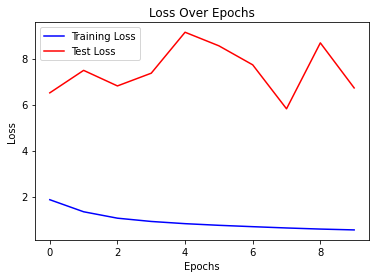

In [23]:
# Running our training loop on our model and plotting the results with our pretrained data.
x, y = trainingLoop(model, schedualer2 ,trainloader2, 10)
plotGraph(x, y, 10)

[1,   500] loss: 1.510
Accuracy of the network on the test images: 52 %
epoch number: 0 .It took 52.60450863838196 seconds for the epoch to run
[2,   500] loss: 1.251
Accuracy of the network on the test images: 56 %
epoch number: 1 .It took 52.62469029426575 seconds for the epoch to run
[3,   500] loss: 1.209
Accuracy of the network on the test images: 53 %
epoch number: 2 .It took 52.62223935127258 seconds for the epoch to run
[4,   500] loss: 1.194
Accuracy of the network on the test images: 55 %
epoch number: 3 .It took 52.5698516368866 seconds for the epoch to run
[5,   500] loss: 1.171
Accuracy of the network on the test images: 55 %
epoch number: 4 .It took 52.59326362609863 seconds for the epoch to run
[6,   500] loss: 1.135
Accuracy of the network on the test images: 55 %
epoch number: 5 .It took 52.61708378791809 seconds for the epoch to run
[7,   500] loss: 1.120
Accuracy of the network on the test images: 57 %
epoch number: 6 .It took 52.553223848342896 seconds for the epoch

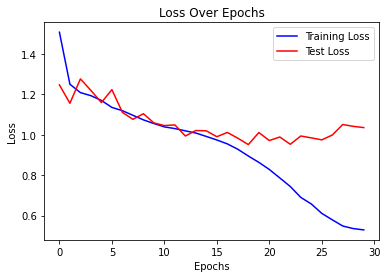

In [24]:
# Running our training loop on our model and plotting the results with our data.
loss_history_train, loss_history_test = trainingLoop(model, schedualer, trainloader, 30, document=True)
plotGraph(loss_history_train, loss_history_test, 30)

In [25]:
# Creating confusion matrix based on our results
nb_classes = 7
confusion_matrix = torch.zeros(nb_classes, nb_classes)
model.eval()
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(proc)
        classes = classes.to(proc)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

matrix = confusion_matrix/confusion_matrix.sum(-1)


Text(0.5, 69.0, 'Predicted label')

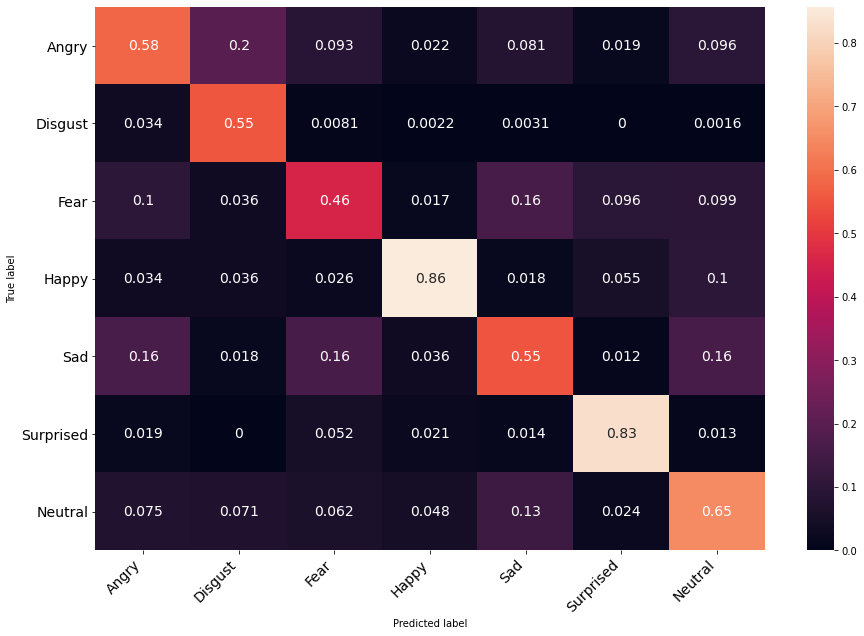

In [26]:
# Plotting our confusion matrix
plt.figure(figsize=(15,10))
label2class = {'0': 'Angry', '1': 'Disgust', '2': 'Fear', '3': 'Happy',
               '4': 'Sad', '5': 'Surprised', '6': 'Neutral'}
class_names = list(label2class.values())
df_cm = pd.DataFrame(matrix, index=class_names, columns=class_names).astype(float)
heatmap = sns.heatmap(df_cm, annot=True, annot_kws={"fontsize":14})

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
